## binarsity results visualisation

All calculations are processed on a HPC2 Cluster. Choose the `filename` to edit the corresponding results.

In [1]:
# -*- coding: utf-8 -*-
%reset -f
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn.apionly as sns
import pylab as pl
from prettytable import PrettyTable
from sklearn.metrics import roc_auc_score, roc_curve
from tick.preprocessing import FeaturesBinarizer

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

## Visualize data

In [2]:
filename = 'default_cb' # 'adult', 'bank', 'churn', 'covtype', 'default_cb', 
                        # 'hepmass_1000', 'higgs', 'ionosphere', 'susy'
with_categorical = False

if with_categorical:
    directory = 'results_with_cate_final' #  results_rf_gb_good
else:
    directory = 'results_final'
    
os.chdir('./datasets/%s' % filename)
df = pd.read_csv("../../../datasets_binarsity/%s/%s" % (filename, filename))
final_setup = True 

print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Learning curves

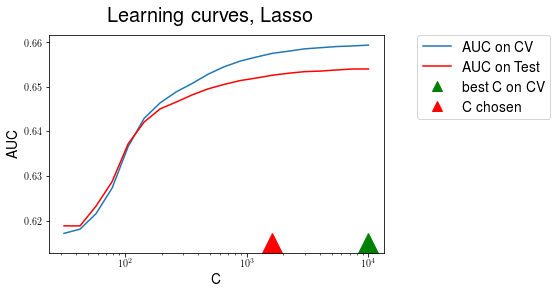

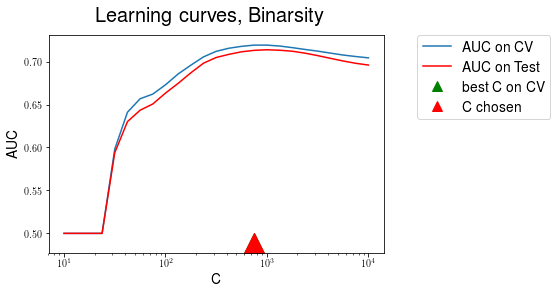

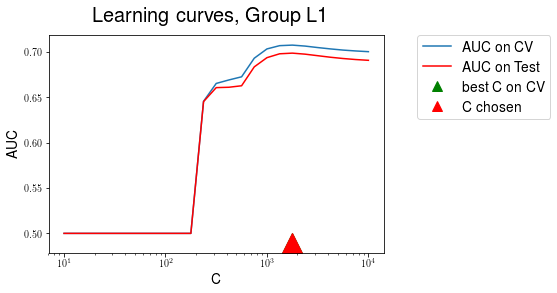

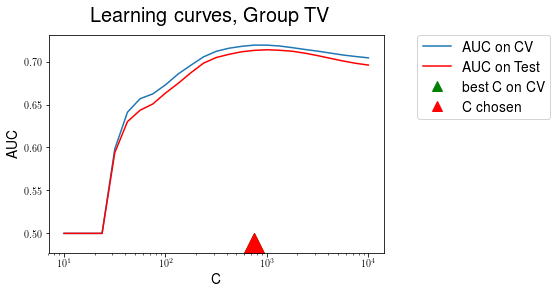

In [3]:
for fname in os.listdir("./%s/learning_curves" % directory):
    if fname[0] != '.':
        learning_curves = np.load("./%s/learning_curves/" % directory + str(fname))
        model_num = fname.split('-')[0]
        fname_ = fname.split('.')[0].split('-')[1].replace('_',' ')  
            
        if int(model_num) in [2, 5]:
            fig = pl.figure()
            ax = fig.add_subplot(111)
            C_grid = learning_curves[:, 0]
            C_grid_ = C_grid
            avg_scores = learning_curves[:, 1]
            score_test = learning_curves[:, 2]
            selection = fname.split('.')[0].split('selection_')[1]
            
            idx_best = np.unravel_index(avg_scores.argmax(), 
                                        avg_scores.shape)[0]
            C_best = C_grid[idx_best]
            if selection == 'min':
                C_chosen = C_best
            if selection == '1st':
                max_ = avg_scores.max()
                min_ = avg_scores.min()
                idx = [i for i, is_up in enumerate(
                    list(avg_scores >= max_ - .05 * (max_ - min_)))
                       if is_up]
                idx_chosen = min(idx) if len(idx) > 0 else idx_best
                C_chosen = C_grid[idx_chosen]
            
            pl.xscale('log')
            ax.plot(C_grid, avg_scores, label="AUC on CV")
            ax.plot(C_grid, score_test , '-r', 
                    label="AUC on Test")
            y_min = ax.get_ylim()[0]
            ax.plot(C_best,y_min,'g^',ms=20, label="best C on CV")
            ax.plot(C_chosen,y_min,'r^',ms=20, label="C chosen")
            pl.suptitle("Learning curves, %s" % fname_, 
                        fontsize=20, fontweight="bold")
            pl.xlabel("C", fontsize=14)
            pl.ylabel("AUC", fontsize=14)
            pl.legend(bbox_to_anchor=(1.1,1), loc=2, borderaxespad=0.,
                      numpoints=1, markerscale=.5, fontsize=14)
            pl.show()

### Convergence check (objective must be decreasing)

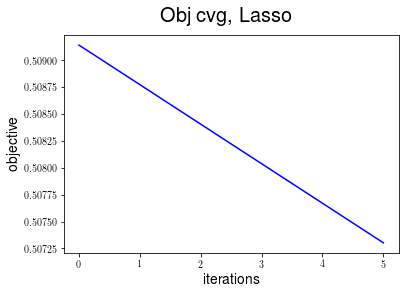

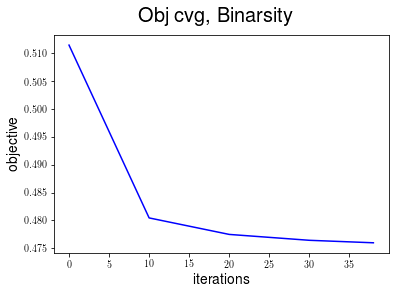

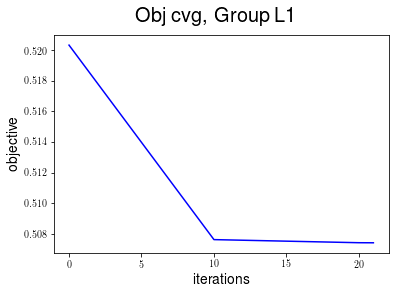

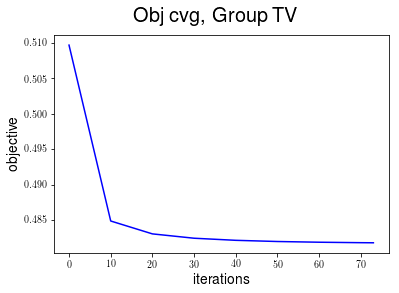

In [4]:
for fname in os.listdir('./%s/cvg' % directory):
    if fname[0] != '.':
        model_num = fname.split('-')[0]
        if ((final_setup and int(model_num) not in [1, 3, 4]) or not final_setup):
            cvg = np.load('./%s/cvg/' % directory + str(fname))
            n_iter = cvg[:, 0]
            obj = cvg[:, 1]
            fname = fname.split('.')[0].split('-')[1].replace('_',' ')
            fig = pl.figure()
            pl.suptitle("Obj cvg, %s" % fname,
                        fontsize=20, fontweight='bold')
            pl.xlabel('iterations', fontsize=14)
            pl.ylabel('objective', fontsize=14)
            pl.plot(n_iter, obj, '-b')
            pl.show()

### Beta coefficients

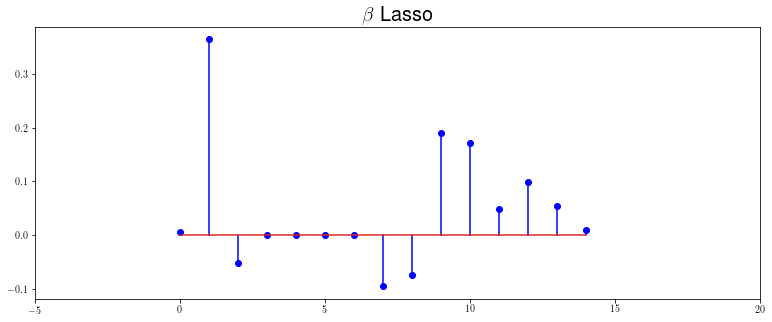

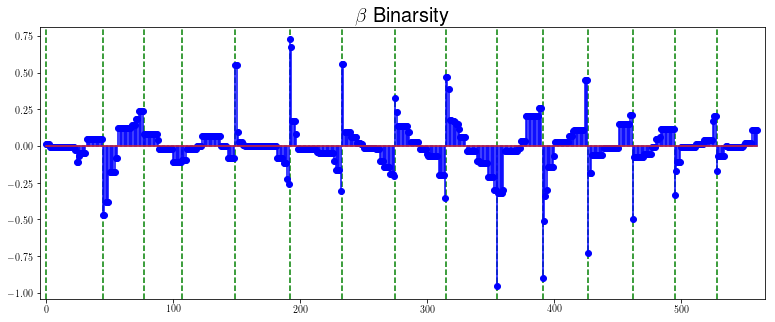

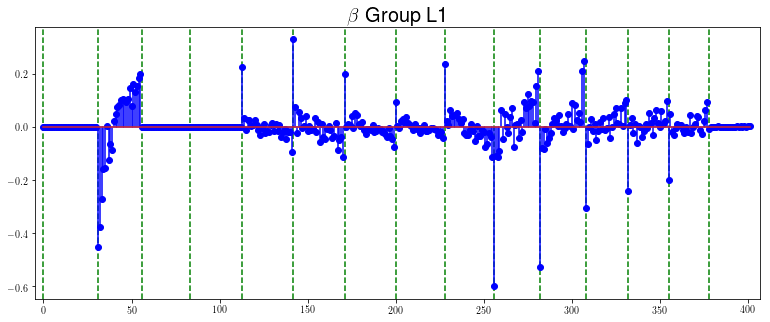

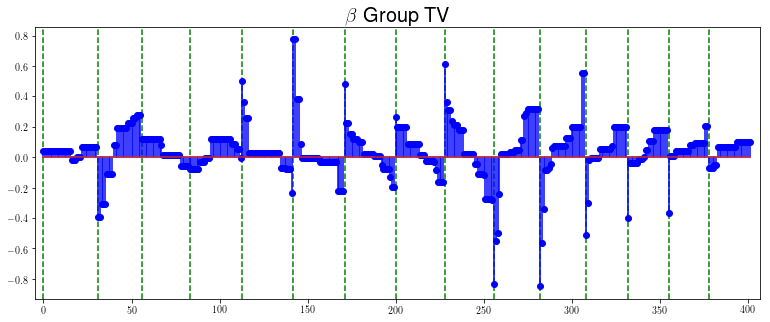

In [5]:
for fname in os.listdir("./%s/beta" % directory):
    if fname[0] not in ['.', 'f', 'b']:
        model_num = fname.split('-')[0]
        if ((final_setup and int(model_num) not in [1, 3, 4]) or not final_setup):
            coeffs = np.load("./%s/beta/%s" % (directory, fname))
            model = fname.split('.')[0].split('-')[1]
            fig = pl.figure(figsize=(13,5))
            ax = fig.add_subplot(111)
            if(int(fname.split('-')[0]) > 2):
                blocks_start = np.load("./%s/beta/blocks_start-%s.npy" % (directory, model))
                for val in blocks_start:
                    ax.axvline(val, color='g', linestyle='--') 
            pl.title(r"$\beta$ %s" % model.replace('_',' '), 
                        fontsize=20, fontweight='bold')
            ax.stem(coeffs, 'b', markerfmt='ob')

            ax.set_xlim([-5, len(coeffs)+5])
            pl.show()

## Performances comparison

In [6]:
results = open("./%s/results.txt" % directory, "r")
print(results.read())

+-------------------+----------+---------+
|       Algos       |   AUC    |  time   |
+-------------------+----------+---------+
|  no pen raw feat  | 0.654177 |  0.319  |
|  l2 pen raw feat  | 0.65404  |  0.139  |
|  l1 pen raw feat  | 0.652568 |  0.105  |
|  no pen bin feat  | 0.710081 |  1.225  |
|  l1 pen bin feat  | 0.710077 |  1.083  |
|  l2 pen bin feat  | 0.710006 |  1.179  |
| bina pen bin feat | 0.716335 |  5.190  |
| group L1 bin feat | 0.696633 |  0.662  |
| group TV bin feat | 0.714313 |  9.564  |
|      svm rbf      | 0.666398 | 204.137 |
|   random forest   | 0.728348 |  25.896 |
| gradient boosting | 0.722264 |  7.446  |
|  	GAM  	    | 0.675118 | 76.528  |
+-------------------+----------+---------+
 global time: 12195.556460380554 s


## ROC curves

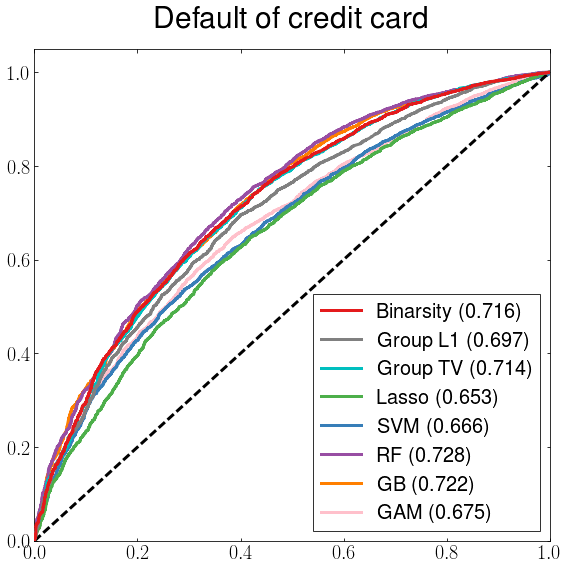

In [7]:
lw = 3
colors = pl.cm.Set1(np.linspace(0, .5, 5))
color_list = [colors[0], 'grey', 'c', colors[2], colors[1], colors[3], colors[4], 'pink']

fig = pl.figure(figsize=(8,8))   
ax = fig.add_subplot(1,1,1)
files_list = os.listdir('./%s/y_pred' % directory)
i=0
for fname in files_list:
    if fname[0] != '.':
        model_num = fname.split('-')[0]
        if ((final_setup and int(model_num) not in [1, 3, 4]) or not final_setup):
             
            y_pred = np.load('./%s/y_pred/' % directory + str(fname))

            if(filename in ['adult', 'covtype']
               and fname in ['2-Group_L1.npy', '2-Group_TV.npy', '9-GAM.npy']):
                y_test = np.load('./%s/y_test_gl1.npy' % directory)
            elif(filename in ['adult'] 
                and fname in ['7-RF.npy', '8-GB.npy', '9-GAM.npy']
                and not with_categorical):
                y_test = np.load('./%s/y_test_.npy' % directory)
            else:
                y_test = np.load('./%s/y_test.npy' % directory)
                    
            if(len(y_test) != len(y_pred)):
                y_pred = y_pred[:len(y_test)]
                y_test = y_test[:len(y_pred)]
                roc_auc = roc_auc_score(y_test, y_pred)
            else:
                roc_auc = roc_auc_score(y_test, y_pred)
            if roc_auc < .5:
                y_pred = 1 - y_pred
                roc_auc = roc_auc_score(y_test, y_pred)    
            
            fname = fname.split('.')[0].split('-')[1].replace('_',' ')
            x, y, threshold = roc_curve(y_test, y_pred) 
            pl.plot(x, y, color=color_list[i], lw=lw, 
                    label = '%s (%0.3f)' % (fname, roc_auc),
                    zorder=5-i)
            if('6-SVM.npy' not in files_list and i == 3):
                i+=1
            i+=1

pl.plot([0, 1], [0, 1], 'k--', lw=lw)
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.05])
pl.tick_params(axis='both', which='major', labelsize=20)

if(filename in ['susy', 'higgs', 'hepmass_1000']):
    title = filename.split('_')[0].upper()
elif(filename == 'bank'):
    title = 'Bank marketing'
elif(filename == 'default_cb'):
    title = 'Default of credit card'
else:
    title = filename.capitalize()

ax.tick_params(axis='both', which='major', direction='in',
               right='on', top='on')
pl.title(title, fontsize=30)
ttl = ax.title
ttl.set_position([.5, 1.03])
leg = pl.legend(loc="lower right", prop={'size':20}, fancybox=False)
leg.get_frame().set_edgecolor('black')
pl.tight_layout()
pl.savefig('./%s/roc_curves.pdf' % directory, bbox_inches='tight')
pl.show()